<a href="https://colab.research.google.com/github/marieangeboum/rs-segsem-dil/blob/master/image_notebook/sam_bbox_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part of this code utilizes the `segment-geospatial` package, which is a Python package designed for segmenting geospatial data using the Segment Anything Model (SAM). This package was created by Professor Dr. Qiusheng Wu.

The `segment-geospatial` package has been adapted from the `segment-anything-eo` repository, originally authored by Aliaksandr Hancharenka. The main goal of the `segment-geospatial` package is to simplify the process of applying SAM to geospatial data analysis, making it more accessible and requiring minimal coding effort.

To use this package, it's available for download and installation via PyPI and conda-forge.

For more information, details, and examples on how to use this package, you can visit Professor Wu's GitHub page at [https://github.com/opengeos/segment-geospatial](https://github.com/opengeos/segment-geospatial).

In [15]:
# Install the necessary libraries
!pip install pycrs segment-geospatial leafmap localtileserver

In [16]:
# Import required libraries
import os
import cv2
import zipfile
import leafmap
import geopandas as gpd
import numpy as np
import rasterio
import glob
from rasterio.merge import merge
from rasterio.features import shapes
from shapely.geometry import shape
from samgeo import SamGeo, SamGeoPredictor, tms_to_geotiff
from segment_anything import sam_model_registry

In [17]:
def read_shapefile(filepath):
    """
    Reads a shapefile and extracts bounding boxes.

    Parameters:
        filepath (str): Path to the shapefile.

    Returns:
        List of bounding boxes.
    """
    gdf = gpd.read_file(filepath)
    condition = gdf['class'] != 0.0
    gdf = gdf[condition]
    return [list(geom.bounds) for geom in gdf.geometry]

In [18]:
def initialize_predictor(img_arr, checkpoint):
    """
    Initializes SamGeoPredictor.

    Parameters:
        img_arr (np.array): Image array.
        checkpoint (str): Path to the model checkpoint.

    Returns:
        An instance of SamGeoPredictor.
    """
    model_type = "vit_h"
    sam = sam_model_registry[model_type](checkpoint=checkpoint)
    predictor = SamGeoPredictor(sam)
    predictor.set_image(img_arr)

    return predictor

In [19]:
def process_clip_boxes(image, clip_boxes, predictor):
    """
    Processes each clip box, creates geojson files, and adds them to the map.

    Parameters:
        image (str): Image file path.
        clip_boxes (list): List of bounding boxes.
        predictor (SamGeoPredictor): An instance of SamGeoPredictor.

    Returns:
        None
    """
    combined_gdf = gpd.GeoDataFrame()

    src_files_to_mosaic = []

    for i, clip_box in enumerate(clip_boxes):
        print(f"Processing clip box {i+1}/{len(clip_boxes)}")
        print(clip_box)
        masks, _, _ = predictor.predict(src_fp=image, geo_box=clip_box)

        # Ensure masks are binary
        masks = (masks > 0).astype('uint8')

        masks_img = f"preds_{i}.tif"
        predictor.masks_to_geotiff(image, masks_img, masks)

        src = rasterio.open(masks_img)
        src_files_to_mosaic.append(src)

        vector = f"feats_{i}.geojson"
        temp_gdf = predictor.geotiff_to_geojson(masks_img, vector, bidx=1)
        combined_gdf = combined_gdf.append(temp_gdf)
        combined_gdf.set_geometry('geometry', inplace=True)

    # Mosaic and write the mosaic raster to disk
    mosaic, out_trans = merge(src_files_to_mosaic)
    out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                    "dtype": 'uint8',
                    "height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "count": 1,
                    "transform": out_trans,
                    "crs": src.crs})

    with rasterio.open('mosaic_mask.tif', "w", **out_meta) as dest:
        dest.write(mosaic[0], 1)

    # Save polygons as separate features in a shapefile
    combined_gdf['geometry'] = combined_gdf.geometry.buffer(0)
    combined_gdf.to_file("separate_features.shp")

In [20]:
# Switch to your image and shapefile instead
image = 'accra_11.tif'
shapefile = 'bbox_accra_11.shp'

# SDefine SAM's model and path
out_dir = "/content/"
checkpoint = os.path.join(out_dir, "sam_vit_h_4b8939.pth")

sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=None,
)

In [21]:
# Read the image
img_arr = cv2.imread(image)

# Extract bounding boxes from the shapefile
clip_boxes = read_shapefile(shapefile)

# Initialize SamGeoPredictor
#predictor = initialize_predictor(img_arr, "/root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth")

# Process each clip box and add vector to the map
#process_clip_boxes(image, clip_boxes, predictor)

In [22]:
import torch
from segment_anything import sam_model_registry

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint="/root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth")
sam.to(device=DEVICE)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [24]:
import cv2
from segment_anything import SamPredictor

mask_predictor = SamPredictor(sam)


mask_predictor.set_image(img_arr)

box = np.array([617, 0, 1023, 563])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

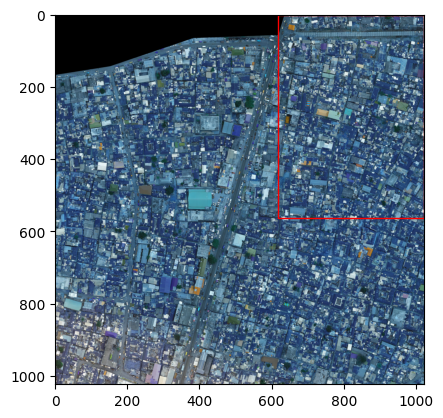

In [36]:
# prompt: je veux superposer la box sur l'image d'origine

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img_arr)

# Create a Rectangle patch
rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


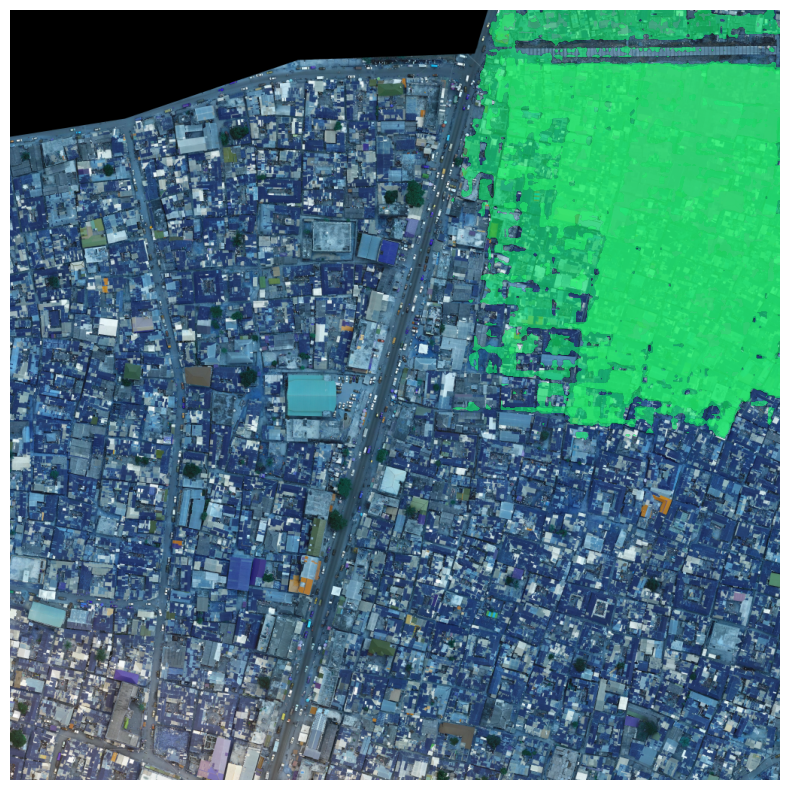

In [34]:
# prompt: je veux superposer les masks générés sur l'image d'origine

import matplotlib.pyplot as plt

# ... (Your existing code)

# Superimpose masks on original image
plt.figure(figsize=(10,10))
plt.imshow(img_arr)
for mask in masks:
  show_mask(mask, plt.gca(), random_color=True)
plt.axis('off')
plt.show()


In [ ]:
# Display the results
mosaic = 'mosaic_mask.tif'
features = 'separate_features.shp'
style={'color': '#a37aa9',}

m = leafmap.Map(center=shapefile)
m.add_raster(mosaic, layer_name="Mask Mosaic")
m.add_vector(features, layer_name='Vector', opacity=0.5, style=style)
m